In [3]:
import pandas_datareader as pdr

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.4 MB/s eta 0:00:00


In [8]:
key = '188f0c77f13f68d5d923878060da60448e070710'

In [9]:
df = pdr.get_data_tiingo('AAPL', api_key = key)

/home/adam/anaconda3/envs/yolactedge_env/lib/python3.9/site-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [10]:
df.to_csv('AAPL.csv')

In [11]:
import pandas as pd

In [25]:
df = pd.read_csv('AAPL.csv')

# Set the date column as the index
df.set_index('date', inplace=True)

# Get the split date
split_date = '2020-08-31'

# Filter the dataframe to only include dates before the split date
pre_split_df = df.loc[:split_date]

# Divide the closing price of all days before the split date by 4
pre_split_df['close'] = pre_split_df['close'] / 4

# Combine the pre-split and post-split dataframes
df = pd.concat([pre_split_df, df.loc[split_date:]])

# Reset the index
df.reset_index(inplace=True)

/tmp/ipykernel_10482/304712022.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_split_df['close'] = pre_split_df['close'] / 4


In [26]:
df.head()
# take all the values before split and divide them by 4
df1 = df.reset_index()['close']

In [27]:
df2 = df.reset_index()['close']

In [28]:
df2.shape

(1257,)

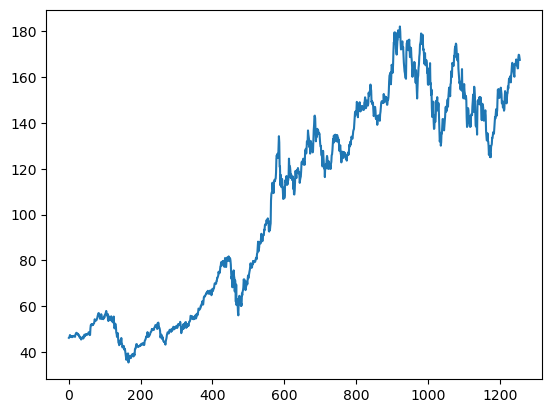

In [29]:
import matplotlib.pyplot as plt

plt.plot(df2)


In [30]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))

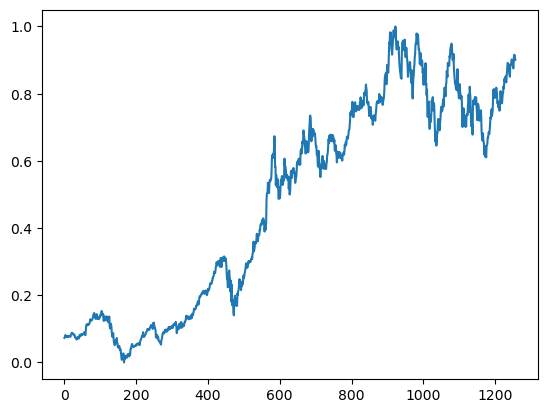

In [31]:
plt.plot(df2)

In [32]:
# Train test split

training_size = int(len(df2)*0.65)
test_size = len(df2) - training_size
train_data, test_data = df2[0:training_size,:], df2[training_size:len(df2),:1]

In [33]:
training_size, test_size

(817, 440)

In [34]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [35]:
X_train, y_train = create_dataset(train_data, 100)
X_test, y_test = create_dataset(test_data, 100)


In [36]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


2023-05-04 12:57:02.258513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 12:57:02.552165: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-10.1/lib64:/usr/local/cuda-11/lib64:/usr/local/cuda-11.1/lib64:/usr/local/cuda-11.2/lib64:/home/adam/anaconda3/envs/yolactedge_env/lib/python3.9/site-packages/tensorrt/
2023-05-04 12:57:02.552179: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [38]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2023-05-04 12:57:33.310803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 12:57:33.311193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-10.1/lib64:/usr/local/cuda-11/lib64:/usr/local/cuda-11.1/lib64:/usr/local/cuda-11.2/lib64:/home/adam/anaconda3/envs/yolactedge_env/lib/python3.9/site-packages/tensorrt/
2023-05-04 12:57:33.331127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-

In [39]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 136ms/step - loss: 0.0471 - val_loss: 0.0545
Epoch 2/100
12/12 [==============================] - 1s 67ms/step - loss: 0.0089 - val_loss: 0.0066
Epoch 3/100
12/12 [==============================] - 1s 68ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 4/100
12/12 [==============================] - 1s 69ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 5/100
12/12 [==============================] - 1s 70ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 6/100
12/12 [==============================] - 1s 68ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 7/100
12/12 [==============================] - 1s 68ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 8/100
12/12 [==============================] - 1s 68ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 9/100
12/12 [==============================] - 1s 68ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 10/100
12/12 [==============================] - 1s 70ms/step - loss: 0.0012 - val_loss: 0.002

In [40]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 16ms/step


In [41]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [42]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

87.92660628005271

In [43]:
math.sqrt(mean_squared_error(y_test, test_predict))

148.94137292258074

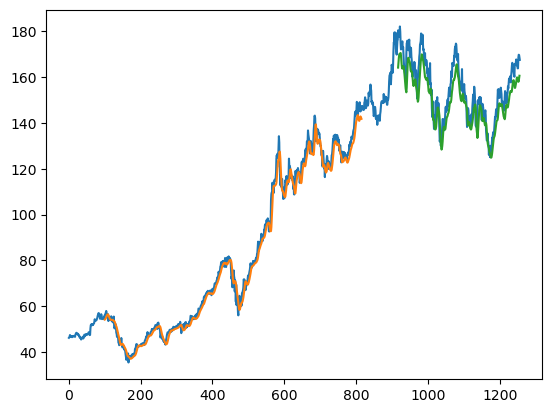

In [46]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [47]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 99)

In [52]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [53]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=99
i=0
while(i<30):
    
    if(len(temp_input)>99):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.75051634 0.73508577 0.689272   0.6756849  0.66107365 0.66059572
 0.68210293 0.66011778 0.65759153 0.64509687 0.6178544  0.64222924
 0.6444141  0.61123154 0.62003926 0.61089016 0.64229752 0.64591619
 0.64987625 0.66872066 0.66817445 0.67739182 0.68544849 0.68046428
 0.68087394 0.69862593 0.72074763 0.73044295 0.7258684  0.74020654
 0.75365708 0.73365196 0.74245967 0.75024324 0.78704447 0.81217035
 0.79325766 0.8131945  0.79455492 0.78738585 0.78834173 0.80773235
 0.80329436 0.81783733 0.80677648 0.79885636 0.77106768 0.77400358
 0.77734915 0.75898267 0.76724418 0.76376206 0.74942391 0.75352053
 0.78847828 0.8075958  0.79237006 0.80104122 0.7854741  0.77120423
 0.78465478 0.79912947 0.80186054 0.82138773 0.81558419 0.83197064
 0.84480669 0.83490655 0.842417   0.85142955 0.837979   0.83367756
 0.85497994 0.86583596 0.88317829 0.89184945 0.8881625  0.87539473
 0.88153964 0.86358283 0.85518477 0.85040539 0.88768456 0.88529487
 0.88543142 0.89389776 0.90181787 0.89512674 0.883

In [58]:
day_new=np.arange(1,100)
day_pred=np.arange(100,130)

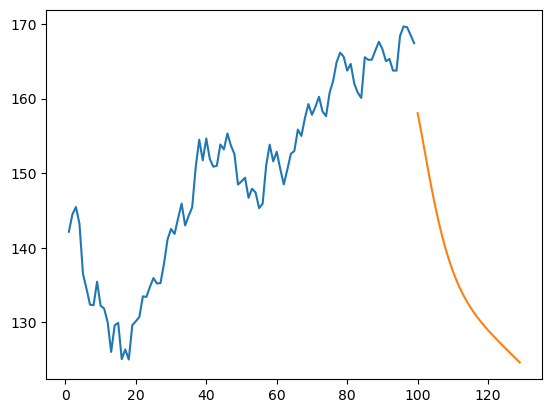

In [59]:

plt.plot(day_new,scaler.inverse_transform(df2[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

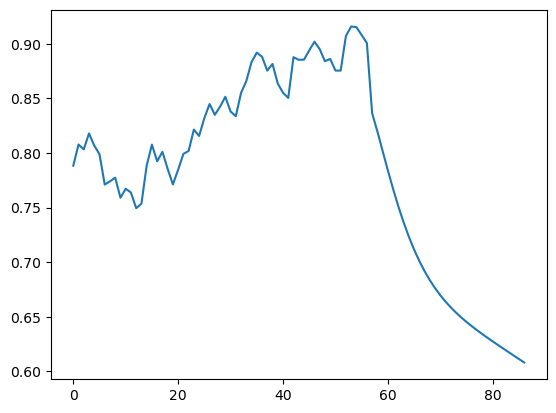

In [60]:
df3=df2.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

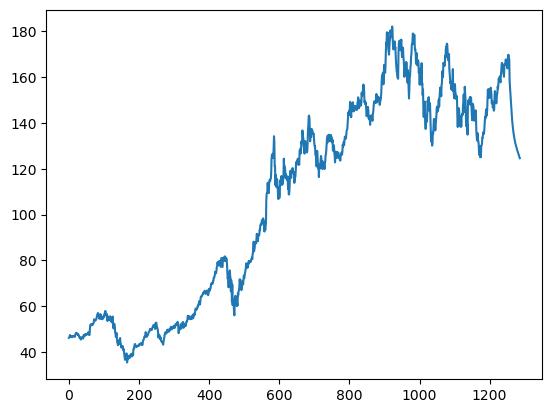

In [61]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)